# Example of language detection by RNN
Inspired from **NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN** by *Sean Robertson* (see [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html))

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Design
### Data
We need to collect samples of words from different languages and produce a training set that maps single words to the corresponding language:

| word | lang |
|---|---|
|play|eng|
|gioco|ita|
|...|...|

### Model the problem as sequence learning by RNN
The input is given by the sequence of characters of each word. Each character is a one-hot vector over the alphabet.

The RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.
![](Z2xbySO.png)

The final `softmax` layer wil produce a probability distribution over the possible languages for each arbitrary sequence of characters.

## Data preparation
We create controlled lists of words per language by taking to most frequent ones. Frequency lists may be found online but they can be also built from corpora. See as a resource [this web site](https://github.com/oprogramador/most-common-words-by-language).

In [2]:
import os

In [3]:
folder = '/Users/flint/Data/wordlists/wiki/'
files = os.listdir(folder)

In [4]:
languages = {}
for filename in files:
    lang = filename.split('.')[0]
    with open(os.path.join(folder, filename), 'r') as infile:
        content = infile.read()
        languages[lang] = []
        for candidate in content.split():
            try:
                w = int(candidate.replace('.', ''))
            except ValueError:
                if len(languages[lang]) < 5000:
                    languages[lang].append(candidate)

In [5]:
languages['english'][:10]

['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']

In [6]:
for lang, lang_list in languages.items():
    print(lang, len(lang_list))

german 5000
french 5000
english 5000
spanish 5000
italian 5000


### Create alphabet

In [7]:
alphabet = set()
for lang_list in languages.values():
    a = set()
    for w in lang_list:
        a = a.union(set(w))
    alphabet = alphabet.union(a)
alphabet = list(alphabet) + [' ']

In [8]:
len(alphabet)

93

### Words to tensors
To represent a single letter, we use a ``one-hot vector`` of size ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. ``b = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix ``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [9]:
import torch

In [10]:
def char2index(char):
    return alphabet.index(char)

def char2tensor(char):
    tensor = torch.zeros(1, len(alphabet))
    tensor[0][char2index(char)] = 1
    return tensor

def word2tensor(word):
    tensor = torch.zeros(len(word), 1, len(alphabet))
    for li, char in enumerate(word):
        tensor[li][0][char2index(char)] = 1
    return tensor

In [11]:
char2tensor('F')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [12]:
word2tensor('Fer').size()

torch.Size([3, 1, 93])

## Network

In [13]:
import torch.nn as nn

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
n_hidden = 64
target_labels = list(languages.keys()) 
rnn = RNN(len(alphabet), n_hidden, len(target_labels))

### Network forward step
To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [16]:
input_chars = word2tensor('Test')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input_chars[0], hidden)

In [17]:
target_labels

['german', 'french', 'english', 'spanish', 'italian']

In [18]:
output

tensor([[-1.6299, -1.5431, -1.7025, -1.5610, -1.6186]],
       grad_fn=<LogSoftmaxBackward0>)

In [19]:
for i, lang in enumerate(target_labels):
    print(lang, float(output[0][i]))
print()
topv, topi = output.topk(1)
print(target_labels[topi])

german -1.6299103498458862
french -1.543081283569336
english -1.7025483846664429
spanish -1.5609750747680664
italian -1.618572473526001

french


### Training

In [20]:
import random

In [21]:
def choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_sample():
    category = choice(target_labels)
    word = choice(languages[category])
    category_tensor = torch.tensor(
        [target_labels.index(category)], dtype=torch.long)
    word_tensor = word2tensor(word)
    return category, word, category_tensor, word_tensor

In [22]:
for i in range(10):
    category, word, category_tensor, word_tensor = random_training_sample()
    print('category =', category, '\t word =', word)

category = french 	 word = combats
category = french 	 word = crainte
category = french 	 word = dernier
category = spanish 	 word = pulso
category = french 	 word = gâteaux
category = spanish 	 word = fuertes
category = italian 	 word = roba
category = italian 	 word = bob
category = french 	 word = roy
category = italian 	 word = amo


In [23]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, word_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, 
    # multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [24]:
n_iters = 100000
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

run = tqdm(list(range(1, n_iters + 1)))

for iteration in run:
    category, word, category_tensor, word_tensor = random_training_sample()
    output, loss = train(category_tensor, word_tensor)
    current_loss += loss

    # Add current loss avg to list of losses
    if iteration % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

In [25]:
import matplotlib.pyplot as plt

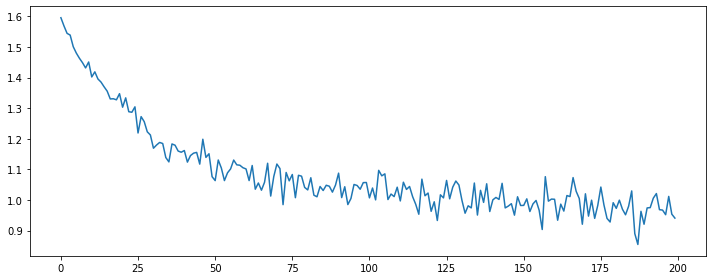

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(all_losses)
plt.tight_layout()
plt.show()

## Evaluate

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [28]:
def evaluate(word_tensor):
    hidden = rnn.initHidden()
    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)
    return output

In [29]:
y_true, y_pred = [], []
for test in range(1000):
    category, word, category_tensor, word_tensor = random_training_sample()
    out = evaluate(word_tensor)
    topv, topi = out.topk(1)
    y_true.append(category)
    y_pred.append(target_labels[topi])

              precision    recall  f1-score   support

     english       0.62      0.42      0.50       219
      french       0.48      0.67      0.56       193
      german       0.85      0.72      0.78       185
     italian       0.63      0.59      0.61       198
     spanish       0.47      0.54      0.50       205

    accuracy                           0.58      1000
   macro avg       0.61      0.59      0.59      1000
weighted avg       0.61      0.58      0.58      1000



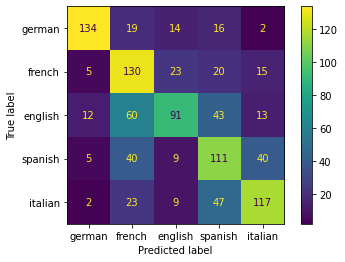

In [30]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=target_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=target_labels)
disp.plot()
plt.show()

### Predictions

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(word2tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, target_labels[category_index]))
            predictions.append([value, target_labels[category_index]])

In [32]:
for sample in range(10):
    category, word, category_tensor, word_tensor = random_training_sample()
    print(category)
    predict(word)
    print()

italian

> soldato
(-0.54) italian
(-0.92) spanish
(-4.60) english

spanish

> nick
(-0.54) english
(-1.82) french
(-2.30) spanish

spanish

> perdieron
(-0.33) spanish
(-1.75) french
(-2.70) english

french

> arabe
(-0.93) spanish
(-1.28) french
(-1.64) italian

french

> recherche
(-0.96) spanish
(-1.33) french
(-1.86) german

italian

> cambiamenti
(-0.13) italian
(-2.50) french
(-3.69) spanish

french

> émotions
(-0.19) french
(-2.14) english
(-3.41) spanish

french

> parle
(-0.68) french
(-1.58) italian
(-1.66) spanish

italian

> coincidenza
(-0.51) italian
(-1.04) spanish
(-3.50) english

german

> haut
(-0.73) german
(-1.02) french
(-2.05) english



In [33]:
predict('io parlo italiano')


> io parlo italiano
(-0.15) italian
(-2.36) spanish
(-3.42) french


In [34]:
predict('io')


> io
(-0.62) italian
(-0.97) spanish
(-2.98) french


In [35]:
predict('do you play football')


> do you play football
(-1.11) english
(-1.14) french
(-1.22) italian
